In [19]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
title_basics = pd.read_csv("/mnt/c/Users/donov/Bureau/IMDB/data/raw/title.basics.tsv", sep="\t", na_values='\\N', nrows = 100000) #sinon le kernel crash
title_ratings = pd.read_csv("/mnt/c/Users/donov/Bureau/IMDB/data/raw/title.ratings.tsv", sep="\t", na_values='\\N', nrows = 100000)


In [21]:
# Création d'un dictionnaire pour stocker les DataFrames
dfs = {
    "title_basics": title_basics,
    "title_ratings": title_ratings
}   

In [22]:
# Première visualisation des données
print("Première visualisation des données\n")


for name, df in dfs.items():
    print(f"DataFrame: {name}")

# Affichage des 5 premières lignes de chaque DataFrame
    print(df.head(), "\n")

# Affichage des informations sur chaque DataFrame
    print(df.info(), "\n")

# Affichage des statistiques descriptives de chaque DataFrame
    print(df.describe(include='all'), "\n")

Première visualisation des données

DataFrame: title_basics
      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short            Poor Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

   isAdult  startYear  endYear  runtimeMinutes                    genres  
0        0     1894.0      NaN             1.0         Documentary,Short  
1        0     1892.0      NaN             5.0           Animation,Short  
2        0     1892.0      NaN             5.0  Animation,Comedy,Romance  
3        0     1892.0      NaN            12.0           Animation,Short  
4        0     1893.0      NaN             1.0                     Short   

<class 'pandas.core.frame.DataFrame'>
Range

In [23]:
# Nettoyage de données 

for name, df in dfs.items():

    # Verification des valeurs manquantes et des doublons dans chaque DataFrame
    print(f"DataFrame: {name}")
    print(f"Valeurs NaN:\n{df.isnull().sum()}")
    print(f"Doublons:{df.duplicated().sum()}")


    # Suppression des doublons
    df.drop_duplicates(inplace=True)
    
    # Suppression des lignes où toutes les valeurs sont NaN
    df.dropna(how='all', inplace=True)

    # Suppression de colonnes inutiles
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
        
    if 'index' in df.columns:
        df.drop(columns=['index'], inplace=True)

    # Suppression des lignes avec des valeurs NaN dans les colonnes essentielles
    essential_columns = ['nconst', 'tconst', 'titleId', 'primaryName', 'primaryTitle', 'originalTitle']
    existing_essential_cols = [col for col in essential_columns if col in df.columns]

    print(f"Colonnes essentielles utilisées dans {name} : {existing_essential_cols}")

    if existing_essential_cols:  # On vérifie qu'il y a au moins une colonne à utiliser
        df.dropna(subset=existing_essential_cols, inplace=True)

    #conversion des dates si startYear et endYear sont des colonnes de la table  
    if 'startYear' in df.columns:
        df['startYear'] = pd.to_numeric(df['startYear'], errors='coerce')

    if 'endYear' in df.columns:
        df['endYear'] = pd.to_numeric(df['endYear'], errors='coerce')

    # Réinitialisation de l'index
    df.reset_index(drop=True, inplace=True)

    # Enregistrement des DataFrames nettoyés dans le dictionnaire
    dfs[name] = df

# Seconde Visualisation apres nettoyage


# Valeurs manquantes et doublons apres nettoyage    
    print(f"Valeurs NaN:\n{df.isnull().sum()}")
    print(f"Doublons:{df.duplicated().sum()}")

# Affichage des 5 premières lignes de chaque DataFrame
    print(df.head(), "\n")

# Affichage des informations sur chaque DataFrame
    print(df.info(), "\n")

# Affichage des statistiques descriptives de chaque DataFrame
    print(df.describe(include='all'), "\n")

DataFrame: title_basics
Valeurs NaN:
tconst                0
titleType             0
primaryTitle          0
originalTitle         0
isAdult               0
startYear            17
endYear           95919
runtimeMinutes    12693
genres             5683
dtype: int64
Doublons:0
Colonnes essentielles utilisées dans title_basics : ['tconst', 'primaryTitle', 'originalTitle']
Valeurs NaN:
tconst                0
titleType             0
primaryTitle          0
originalTitle         0
isAdult               0
startYear            17
endYear           95919
runtimeMinutes    12693
genres             5683
dtype: int64
Doublons:0
      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short            Poor Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  t

In [6]:
### PARTIE MODELISATION PREDICTIVE 

In [7]:
# Problématique :  Prédiction de la note 'AverageRating' d'un film à partir des autres variables

In [24]:
# Packages complémentaires

from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy import sparse as sp
from sklearn.model_selection import GridSearchCV

In [9]:
# Phase 1 : encoding des variables catégorielles (genres,titleType..)

In [25]:
# genres : séparation des genres et encodages multilabel
title_basics['genres_split'] = title_basics['genres'].fillna('').str.split(',')
title_basics['genres_split'] = title_basics['genres_split'].apply(lambda x: [] if x == [''] else x)
mlb = MultiLabelBinarizer(sparse_output=True)
genres_sparse = mlb.fit_transform(title_basics['genres_split'])
genres_encoded = pd.DataFrame.sparse.from_spmatrix(genres_sparse, columns = mlb.classes_)

# titleType : One_hot encoding
ohe = OneHotEncoder(sparse_output=True)
titleType_encoded_sparse = ohe.fit_transform(title_basics[['titleType']])
titleType_encoded = pd.DataFrame.sparse.from_spmatrix(titleType_encoded_sparse, columns=ohe.get_feature_names_out(['titleType']))


# Merge

title_basics_sparse = pd.DataFrame.sparse.from_spmatrix(
    sp.hstack([genres_sparse, titleType_encoded_sparse]),
    columns=list(mlb.classes_) + list(ohe.get_feature_names_out(['titleType']))
)

In [26]:
# Nouveau data frame avec title basics et title ratings
data = pd.merge(title_basics, title_ratings, on = 'tconst', how = 'left')
data.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genres_split,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"Documentary,Short","[Documentary, Short]",5.7,2165.0
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"Animation,Short","[Animation, Short]",5.5,296.0
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892.0,NaN,5.0,"Animation,Comedy,Romance","[Animation, Comedy, Romance]",6.5,2219.0
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12.0,"Animation,Short","[Animation, Short]",5.3,190.0
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,Short,[Short],6.2,2957.0


In [27]:
# Colonnes numériques
numerical = data[['startYear', 'numVotes']].to_numpy()
numerical_sparse = sp.csr_matrix(numerical)

# Merge tout ensemble
X_sparse = sp.hstack([numerical_sparse, genres_sparse, titleType_encoded_sparse])

# DataFrame sparse si besoin
X = pd.DataFrame.sparse.from_spmatrix(
    X_sparse,
    columns=['startYear','numVotes'] + list(mlb.classes_) + list(ohe.get_feature_names_out(['titleType']))
)
y = data['averageRating']

In [28]:
# Phase 2 : Préparation des X et y

X = pd.concat(
    [data[['startYear','numVotes']].reset_index(drop=True),
     genres_encoded.reset_index(drop=True),
     titleType_encoded.reset_index(drop=True)],
    axis=1
)
y = data['averageRating']


# Phase 3 : préparation des différents sets de données
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

X_train = X_train[~pd.isna(X_train).any(axis=1)]
y_train = y_train[X_train.index]

X_test = X_test[~pd.isna(X_test).any(axis=1)]
y_test = y_test[X_test.index]

In [29]:
# Régression linéaire

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

print("MSE RF:", mean_squared_error(y_test, y_pred))
print("R^2 RF:", r2_score(y_test, y_pred))

MSE RF: 0.9334846387489194
R^2 RF: 0.18833178986470533


/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [30]:
# Comparaison R^2 train et R^2 test

print("R^2 train RF:", r2_score(y_train, y_pred_train))
print("R^2 test RF:", r2_score(y_test, y_pred))

# Si R^2_train >> R^2 test = overfitting
# Si R^2_train ~ R^2 test = assez bonne généralisation

R^2 train RF: 0.17537817482688334
R^2 test RF: 0.18833178986470533


In [31]:
# Random Forest

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_rf_train = rf.predict(X_train)

print("MSE RF :", mean_squared_error(y_test, y_pred_rf))
print("R^2 RF :", r2_score(y_test, y_pred_rf))

/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


MSE RF : 0.8677656937626232
R^2 RF : 0.24547464603478353


In [32]:
# Définition du modèle 3
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestRegressor(random_state=42)

# Grille de recherche (plus large que GridSearch)
param_dist = {
    'n_estimators': np.arange(100, 500, 50),  # plus d'arbres possibles
    'max_depth': [None] + list(np.arange(5, 30, 5)),  # profondeur plus large
    'min_samples_split': [2, 5, 10, 20],  # split minimum
    'min_samples_leaf': [1, 2, 4, 8],  # feuilles minimum
    'max_features': ['sqrt', 'log2', None],  # variables par split
    'bootstrap': [True, False]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=50,  # nombre de combinaisons testées
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Entraînement
random_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres :", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with spa

[CV] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=  16.8s
[CV] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=350; total time=  37.2s


/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/

[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=250; total time=  17.3s
[CV] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=350; total time=  39.7s


/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=250; total time=  17.7s
[CV] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=350; total time=  40.0s


/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with spa

[CV] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  31.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=450; total time=  47.1s


/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=250; total time=  18.1s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=8, min_samples_split=20, n_estimators=300; total time=  18.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=450; total time=  47.8s


/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with spa

[CV] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=  15.9s
[CV] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  30.7s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=8, min_samples_split=20, n_estimators=300; total time=  17.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=450; total time=  44.8s
[CV] END bootstrap=True, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=  15.7s
[CV] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  31.2s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=8, min_samples_split=20, n_estimators=300; total time=  17.3s
[CV] END bootstrap=True, max_depth=None

/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with spa

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}
Detailed tracebacks of the workers should have been printed to stderr in the executor process if faulthandler was not disabled.

In [33]:
# Prédictions avec le meilleur modèle
best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Scores
print("MSE RF :", mean_squared_error(y_test, y_pred_rf))
print("R^2 RF :", r2_score(y_test, y_pred_rf))
print("R^2_train RF:", r2_score(y_train, best_rf.predict(X_train)))

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [34]:
# Comparaison et évaluation des résulats
rf.fit(X_train, y_train)
importances = rf.feature_importances_
for feat, score in zip(X.columns, importances):
    print(f"{feat} : {score}")

/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


startYear : 0.2685831279015165
numVotes : 0.38799161632157136
Action : 0.013869489887261818
Adult : 0.002484227969904154
Adventure : 0.01198652114000313
Animation : 0.005861751014464567
Biography : 0.005289429238151757
Comedy : 0.021280658467444213
Crime : 0.015598167284737714
Documentary : 0.02117314071305453
Drama : 0.031273136827198914
Family : 0.009705418409972433
Fantasy : 0.008161756705550546
Film-Noir : 0.0005774208213896289
Game-Show : 0.0005696951862006466
History : 0.007258123504771798
Horror : 0.028454533829473157
Music : 0.008863580152761336
Musical : 0.00892985349593605
Mystery : 0.008358844989910644
News : 0.001370189337421498
Reality-TV : 0.00011878268503570247
Romance : 0.017478829219708343
Sci-Fi : 0.011153358505643148
Short : 0.004562237706167542
Sport : 0.003979773434281825
Talk-Show : 0.000681717733287509
Thriller : 0.009071320469274368
War : 0.009110778284671684
Western : 0.008227163447618271
titleType_movie : 0.04868576796250687
titleType_short : 0.001237726022994

/mnt/c/Users/donov/Bureau/IMDB/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


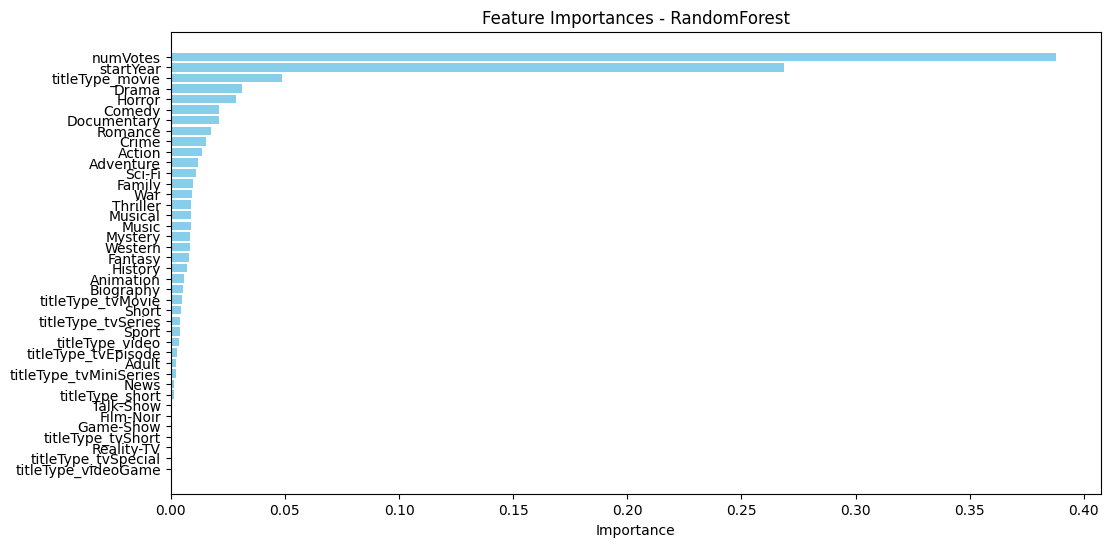

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

rf.fit(X_train, y_train)

# Créer un DataFrame des importances
feat_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})

# Trier par importance décroissante
feat_importances = feat_importances.sort_values(by='importance', ascending=False)

# Graphique
plt.figure(figsize=(12,6))
plt.barh(feat_importances['feature'], feat_importances['importance'], color='skyblue')
plt.gca().invert_yaxis()  # Pour que la plus importante soit en haut
plt.xlabel('Importance')
plt.title('Feature Importances - RandomForest')
plt.savefig("/mnt/c/Users/donov/Bureau/IMDB/outputs/Feature Importances - RandomForest.png")
plt.show()


In [36]:
# Comparaison R^2 train et R^2 test

print("R^2_train RF:", r2_score(y_train, y_pred_rf_train))
print("R^2 RF:", r2_score(y_test, y_pred_rf))

# Si R^2_train >> R^2 test = overfitting
# Si R^2_train ~ R^2 test = assez bonne généralisation

R^2_train RF: 0.8533282232750983
R^2 RF: 0.24547464603478353


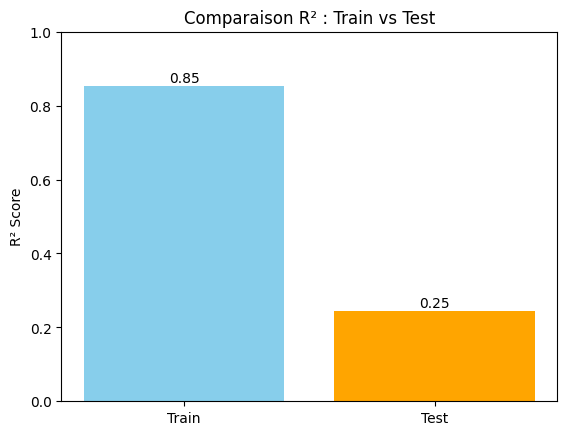

In [37]:
#Courbe d'analyse de R^2 train et R^2 test

# Valeurs de R²
r2_train = r2_score(y_train, y_pred_rf_train)
r2_test = r2_score(y_test, y_pred_rf)

# Plot
plt.bar(['Train', 'Test'], [r2_train, r2_test], color=['skyblue', 'orange'])
plt.ylabel('R² Score')
plt.title('Comparaison R² : Train vs Test')

# Afficher les valeurs au-dessus des barres
for i, v in enumerate([r2_train, r2_test]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

plt.ylim(0, 1)  # pour mieux voir l'échelle
plt.savefig("/mnt/c/Users/donov/Bureau/IMDB/outputs/Comparaison R^2 train vs R^2 Test.png")
plt.show()

